In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
import nibabel as nib
import matplotlib.pyplot as plt
import os
from PIL import Image
import os
import numpy as np
import nibabel as nib
import msvcrt
import cv2

In [3]:
base_path = r'D:\test\BIOM5202_Project\Images\Raw Images\Set1'
file_name_substring_flair = 'flair.png'
file_name_substring_seg = 'seg.png'

All_images_flair = np.zeros((240, 240, 12), dtype=np.uint8)  # Changed dtype to np.uint8
All_images_seg = np.zeros((240, 240, 12), dtype=np.uint8)    # Changed dtype to np.uint8

for folder_number in range(1, 13):
    folder_path = os.path.join(base_path, str(folder_number))

    # Get a list of files in the folder
    files_flair = [file for file in os.listdir(folder_path) if file_name_substring_flair in file]
    files_seg = [file for file in os.listdir(folder_path) if file_name_substring_seg in file]

    # Check if any file contains the specified substring
    if files_flair and files_seg:
        file_path_flair = os.path.join(folder_path, files_flair[0])
        file_path_seg = os.path.join(folder_path, files_seg[0])

        # Open the image files using PIL
        img_flair = np.array(Image.open(file_path_flair), dtype=np.uint8)  # Changed dtype to np.uint8
        img_seg = np.array(Image.open(file_path_seg), dtype=np.uint8)      # Changed dtype to np.uint8

        # Convert the images to grayscale
        img_flair = cv2.cvtColor(img_flair, cv2.COLOR_BGR2GRAY)
        img_seg = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

        # Assign the images to the All_images arrays
        All_images_flair[:, :, folder_number - 1] = img_flair
        All_images_seg[:, :, folder_number - 1] = img_seg


In [4]:
def IoU(y_true, y_pred):
    """
    Calculate the Intersection over Union (IoU) of two numpy arrays.

    :param y_true: Ground truth binary array.
    :param y_pred: Predicted binary array.
    :return: IoU score.
    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_similarity(y_true, y_pred):
    """
    Calculate the Dice Similarity Coefficient for two numpy arrays.

    :param y_true: Ground truth binary array.
    :param y_pred: Predicted binary array.
    :return: Dice similarity score.
    """
    intersection = np.logical_and(y_true, y_pred)
    dice_score = 2. * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

def draw_intersection_of_binary_images_v3(image1, image2):
    """
    Draw the intersection of two binary images, where intersection is red, non-intersection is white,
    and background is black.

    Parameters:
    image1, image2 (numpy.ndarray): Two binary images of the same size.

    Returns:
    numpy.ndarray: Image highlighting the intersection in red, non-intersection in white, and background in black.
    """
    if image1.shape != image2.shape:
        raise ValueError("The input images must have the same size")

    # Create an image to display the result
    result_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection (red)
    intersection = (image1 == 255) & (image2 == 255)
    result_image[intersection] = [255, 0, 0]

    # Non-intersecting parts of the images (white)
    non_intersection = ((image1 == 255) | (image2 == 255)) & ~intersection
    result_image[non_intersection] = [255, 255, 255]

    # Background remains black (as initialized)

    return result_image

The thereshold using Ostu is equal: 51
The thereshold using maximum intensity-100 is equal: 155


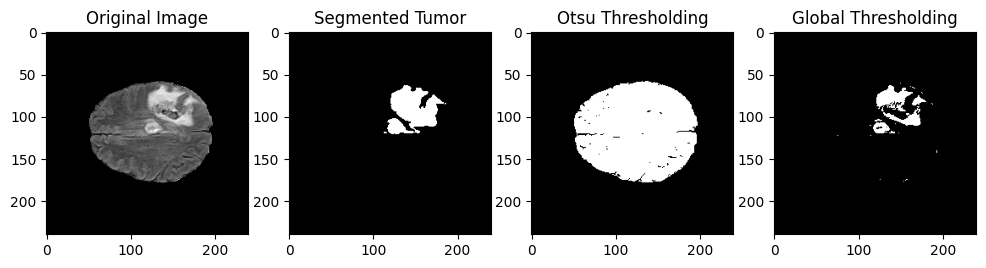

0.5915074309978768
0.004673900643542099


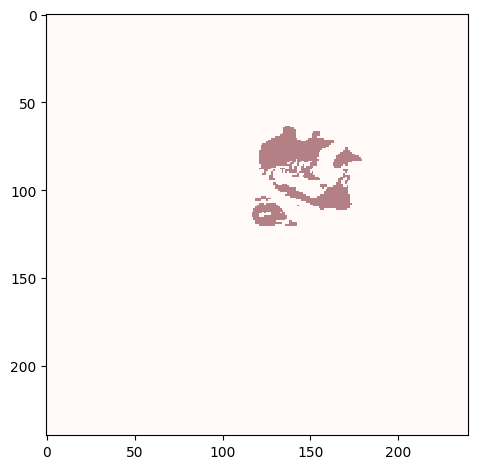

In [15]:
# Choose a slice and time point for demonstration
numberOflyer=4
image_slice = All_images_flair[:,:,numberOflyer]
segmented_image=All_images_seg[:,:,numberOflyer]
thresh1 = threshold_otsu(image_slice)
thresh2 = np.max(image_slice)-100


print("The thereshold using Ostu is equal:",thresh1)
print("The thereshold using maximum intensity-100 is equal:",thresh2)

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(image_slice, (5, 5), 0)

# Otsu's thresholding
thresh1 = threshold_otsu(image_slice)
binary_mask_otsu = image_slice > thresh1

# Simple global threshold (you can adjust this threshold value)
binary_mask_global = image_slice > thresh2



# Apply Otsu's thresholding
_, segmented_tumor_ostu = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Apply binary thresholding
ret, binary_image = cv2.threshold(blurred_image, thresh2, 255, cv2.THRESH_BINARY)



plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1), plt.imshow(image_slice, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 4, 2), plt.imshow(segmented_image, cmap='gray'), plt.title('Segmented Tumor')
plt.subplot(1, 4, 3), plt.imshow(binary_mask_otsu, cmap='gray'), plt.title('Otsu Thresholding')
plt.subplot(1, 4, 4), plt.imshow(binary_mask_global, cmap='gray'), plt.title('Global Thresholding')

plt.show()

aa=IoU(segmented_image,binary_mask_global)
print(aa)
bb=dice_similarity(segmented_image,binary_mask_global)
print(bb)


overlap_mask = np.logical_and(segmented_image,binary_mask_global)
imshow(overlap_mask, cmap='Reds', alpha=0.5)

In [6]:
# Choose a slice and time point for demonstration
for layer_index in range(All_images_flair.shape[2]):
    image_slice = All_images_flair[:,:,layer_index]
    segmented_image=All_images_seg[:,:,layer_index]
    thresh1 = threshold_otsu(image_slice)
    thresh2 = np.max(image_slice)-100
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image_slice, (5, 5), 0)

    # Otsu's thresholding
    thresh1 = threshold_otsu(image_slice)
    binary_mask_otsu = image_slice > thresh1

    # Simple global threshold (you can adjust this threshold value)
    binary_mask_global = image_slice > thresh2



    # Apply Otsu's thresholding
    _, segmented_tumor_ostu = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Apply binary thresholding
    ret, binary_image = cv2.threshold(blurred_image, thresh2, 255, cv2.THRESH_BINARY)



    # Display the original image and segmented tumor
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1), plt.imshow(image_slice, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 4, 2), plt.imshow(segmented_image, cmap='gray'), plt.title('Segmented Tumor')
    plt.subplot(1, 4, 3), plt.imshow(binary_mask_otsu, cmap='gray'), plt.title('Otsu Thresholding')
    plt.subplot(1, 4, 4), plt.imshow(binary_mask_global, cmap='gray'), plt.title('Global Thresholding')
    # Save the subplot image with the name of layer_index
    plt.savefig(os.path.join('resulted_images', f'binary_masks_folder_{layer_index}.png'))

    # Clear the current figure to avoid overlapping subplots
    plt.clf()


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [7]:



# Define the image paths
image_path_flair = r'D:\code\archive_4\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii'
image_path_seg = r'D:\code\archive_4\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii'
image_path_t1 = r"D:\code\archive_4\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii"
image_path_t1ce = r"D:\code\archive_4\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii"
image_path_t2 = r"D:\code\archive_4\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii"

# Load the image data for each modality
flair_img = nib.load(image_path_flair)
seg_img = nib.load(image_path_seg)
t1_img = nib.load(image_path_t1)
t1ce_img = nib.load(image_path_t1ce)
t2_img = nib.load(image_path_t2)

# Extract data as numpy ndarray
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()

# Get the image shape
height, width, depth = flair_data.shape

# Select a random layer number
layer = np.random.randint(0, depth)

# Define a channel to look at
channels = [flair_data, t1_data, t1ce_data, t2_data, seg_data]
channel_names = ['FLAIR', 'T1', 'T1ce', 'T2', 'Segmentation']

# Create subplots for each modality
fig, axes = plt.subplots(1, len(channels), figsize=(15, 3))

for i, (data, name) in enumerate(zip(channels, channel_names)):
    axes[i].imshow(data[:, :, layer], cmap='gray')
    axes[i].set_title(name)
    axes[i].axis('off')

plt.show()

FileNotFoundError: No such file or no access: 'D:\code\archive_4\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii'

NameError: name 'chico' is not defined

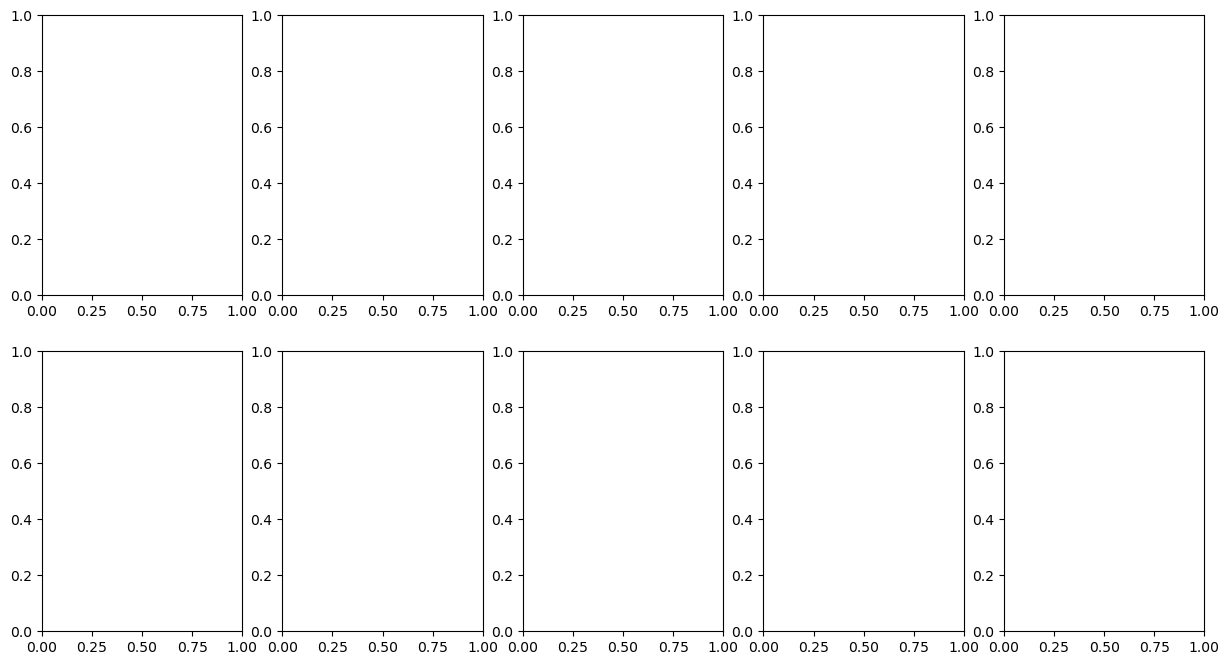

In [ ]:
th_values = np.linspace(0, 1, 11)
fig, axis = plt.subplots(2, 5, figsize=(15,8))
chico_gray = rgb2gray(chico)
for th, ax in zip(th_values, axis.flatten()):
    
    chico_binarized = chico_gray < th
    ax.imshow(chico_binarized)
    ax.set_title('$Threshold = %.2f$' % th)

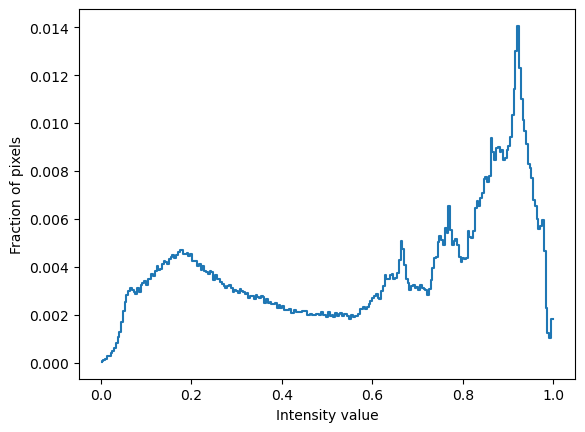

In [ ]:
freq, bins = histogram(chico_gray)
plt.step(bins, freq*1.0/freq.sum())
plt.xlabel('Intensity value')
plt.ylabel('Fraction of pixels');

Otsu’s method assumes that the image is composed of a background and a foreground. This method works by minimizing the intra-class variance or maximizing the inter-class variance. Let’s see how this works.

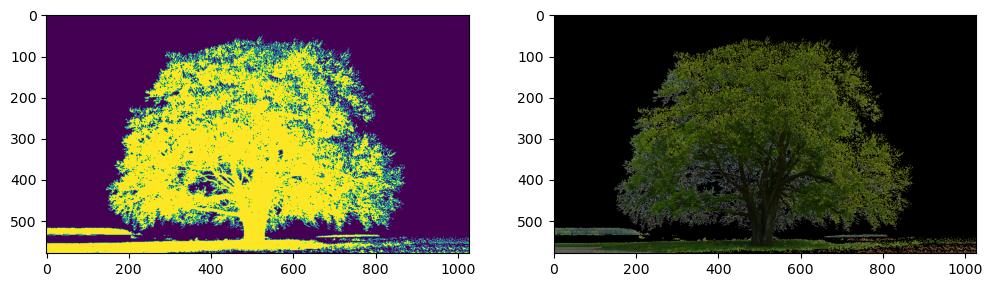

In [ ]:
def masked_image(image, mask):
    r = image[:,:,0] * mask
    g = image[:,:,1] * mask
    b = image[:,:,2] * mask
    return np.dstack([r,g,b])
fig, ax = plt.subplots(1, 2, figsize=(12,6))
thresh = threshold_otsu(chico_gray)
chico_otsu  = chico_gray < thresh
ax[0].imshow(chico_otsu)
filtered = masked_image(chico, chico_otsu)
ax[1].imshow(filtered)

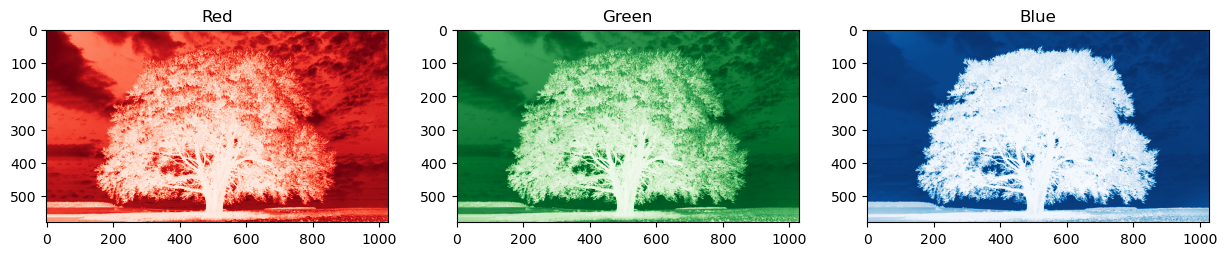

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,6))
ax[0].imshow(chico[:,:,0], cmap='Reds')
ax[0].set_title('Red')
ax[1].imshow(chico[:,:,1], cmap='Greens')
ax[1].set_title('Green')
ax[2].imshow(chico[:,:,2], cmap='Blues')
ax[2].set_title('Blue');

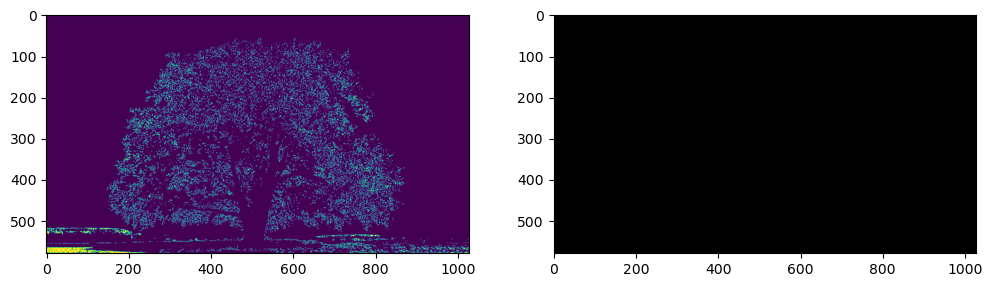

In [ ]:
figure, ax = plt.subplots(1,2, figsize=(12,6))
chico_red = chico[:,:,0]
chico_green = chico[:,:,1]
chico_blue = chico[:,:,2]
binarized = ((chico_red < 200) & (chico_red > 75) & 
             (chico_green < 120) & (chico_green > 50) & 
             (chico_blue > 20))
opened = area_opening(binarized, 5000)
ax[0].imshow(binarized)
ax[1].imshow(masked_image(chico, opened))

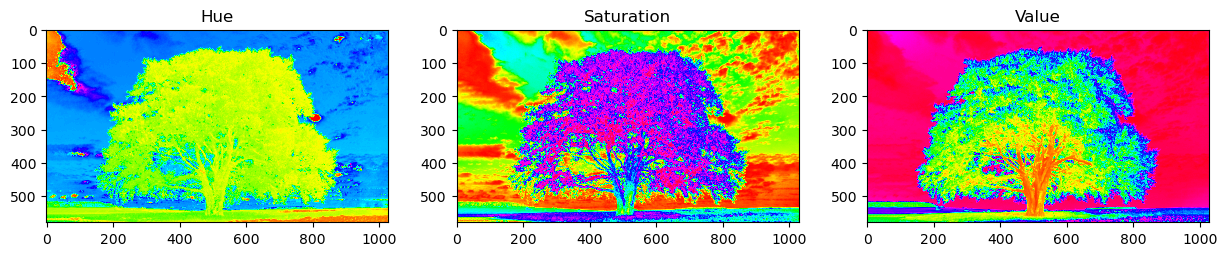

In [ ]:
chico_hsv = rgb2hsv(chico)
fig, ax = plt.subplots(1, 3, figsize=(15,6))
ax[0].imshow(chico_hsv[:,:,0], cmap='hsv')
ax[0].set_title('Hue')
ax[1].imshow(chico_hsv[:,:,1], cmap='hsv')
ax[1].set_title('Saturation')
ax[2].imshow(chico_hsv[:,:,2], cmap='hsv')
ax[2].set_title('Value');

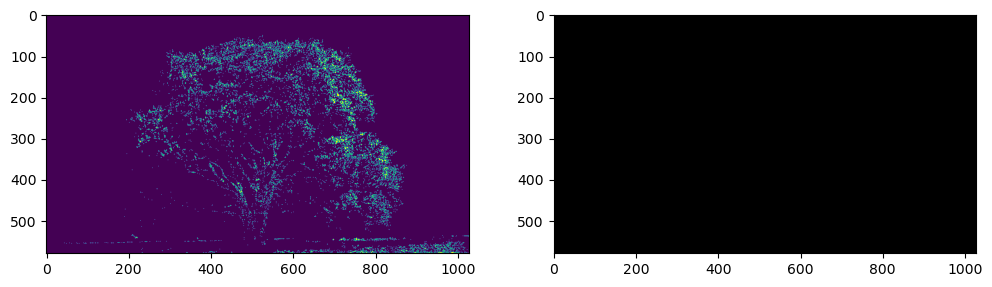

In [ ]:
figure, ax = plt.subplots(1,2, figsize=(12,6))
chico_hue = chico_hsv[:,:,0] 
chico_sat = chico_hsv[:,:,1]
chico_val = chico_hsv[:,:,2]
binarized_hsv = ((chico_hue < 0.18) & (chico_hue > 0.05) & 
                 (chico_sat > 0.55)  & (chico_sat < 0.80))
opened = area_opening(binarized_hsv, 5000)
ax[0].imshow(binarized_hsv)
ax[1].imshow(masked_image(chico, opened))

https://medium.com/swlh/image-processing-with-python-image-segmentation-using-thresholding-methods-423ecdaf8ab4